In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# ## convert csv files to numpy arrays for faster processing in the future
# latency_tests = [[1,3],[2,5],[3,3],[4,3],[5,1],[6,2],[7,1],[8,2]]
# for t,s in latency_tests:
#     for sample in range(1,s+1):
#         filename = f'csv_data/test{t}/sample{sample}.csv'
#         print("processing",filename)
#         with open(f't{t}-s{sample}.npy','wb') as f:
#             np.save(f,get_data_from_csv(filename).to_numpy())
        

In [20]:
def get_data_from_csv(filename):
    return pd.read_csv(filename,skiprows=19) 

def get_data_from_npy(filename):
    data = np.load(filename)
    return pd.DataFrame({'Time (s)': data[:, 0], 'Channel 1 (V)': data[:, 1],'Channel 2 (V)': data[:, 2]})

def get_edge_times(data, channel):
    '''Return the times in us of rising and falling edges on the 
    specified channel'''
    sampling_interval_us = 2
    signal  = (data[channel]>2).astype(int) # Signal converted to int 0/1  for low high.
    rising_edges  = np.where(np.diff(signal)== 1)[0]*sampling_interval_us
    falling_edges = np.where(np.diff(signal)==-1)[0]*sampling_interval_us
    return rising_edges, falling_edges

def complete_pulses(rising_edges, falling_edges):
    '''Ensure first edge is rising and there are the same number of rising
    and falling edges.'''
    if rising_edges[0] > falling_edges[0]:
        falling_edges = falling_edges[1:] # Ensure first edge is rising.
    if len(rising_edges) > len(falling_edges):
        rising_edges = rising_edges[:len(falling_edges)] # Ensure same number of rising and falling edges.
    return rising_edges, falling_edges

def input_leads(input_rising , input_falling, output_rising, output_falling):
    '''Ensure the first input pulse occurs before the first output
    pulse and last output pulse follows last input pulse.'''
    if input_rising[0] > output_rising[0]:   # Ensure first pulse is input.
        output_rising  = output_rising[1:]
        output_falling = output_falling[1:]
    if input_rising[-1] > output_rising[-1]: # Ensure last pulse is output.
        input_rising   = input_rising[:-1]
        input_falling  = input_falling[:-1]
    return input_rising, input_falling, output_rising, output_falling

def latency(data,csv=False):
    input_rising , input_falling  = get_edge_times(data, 'Channel 2 (V)')
    output_rising, output_falling = get_edge_times(data, 'Channel 1 (V)')
    input_rising , input_falling  = complete_pulses(input_rising, input_falling)
    output_rising, output_falling = complete_pulses(output_rising, output_falling)
    input_rising , input_falling, output_rising, output_falling = input_leads(
        input_rising , input_falling, output_rising, output_falling) 

    rising_latencies  = output_rising  - input_rising
    falling_latencies = output_falling - input_falling

    all_latencies = np.hstack([rising_latencies, falling_latencies])
    mean = np.mean(all_latencies)
    stddev = np.std(all_latencies)

    fig_no = 1
    title = ''
    plt.figure(fig_no, clear=True, figsize=[3,3])
    bins = np.arange(np.min(all_latencies)-50, np.max(all_latencies)+50, 20)
    plt.hist(all_latencies , bins)
    plt.ylabel('# events')
    plt.xlabel('Latency (μs)')
    plt.title('Response latency ' + title)
    plt.tight_layout()

    if csv:
        print(f'{np.min(all_latencies):.0f},{np.max(all_latencies):.0f},{np.mean(all_latencies<2000) :.4f},{np.mean(all_latencies<1000) :.4f}')
    else:
        print(f'{len(all_latencies)} samples, {mean:.1f} ± {stddev:.1f} µs')
        print(f'min:{np.min(all_latencies):.0f}, max:{np.max(all_latencies):.0f}')
        print(f'Fraction of edge latencies < 2ms: {np.mean(all_latencies<2000) :.4f}')
        print(f'Fraction of edge latencies < 1ms: {np.mean(all_latencies<1000) :.4f}')
        plt.show()
    return all_latencies
    
def timing_accuracy(data, target_dur_ms=10, fig_no=1, title=''):
    '''Plot the distribution of discrepancies between the duration
    of high pulses in the signal and the target duration.'''


    rising_edges, falling_edges  = get_edge_times(data, 'Channel 1 (V)')
    rising_edges, falling_edges = complete_pulses(rising_edges, falling_edges)
    
    pulse_durs = falling_edges - rising_edges
    dur_errors = pulse_durs-target_dur_ms*1000
     
    # Plotting

    plt.figure(fig_no, clear=True, figsize=[3,3])
    bins = np.arange(np.min(dur_errors)-50, np.max(dur_errors)+50, 20)
    plt.hist(dur_errors, bins)
    plt.ylabel('# events')
    plt.xlabel('Timing error (μs)')
    plt.title('Timing accuracy ' + title)
    plt.tight_layout()

    print(f'Error mean:{np.mean(dur_errors):.0f}, SD:{np.std(dur_errors):.0f}, '
          f'min:{np.min(dur_errors):.0f}, max:{np.max(dur_errors):.0f}')
    print(f'Fraction of errors < 1ms: {np.mean(dur_errors<1000) :.4f}')
    
    plt.show()
    return dur_errors


3422 samples, 560.8 ± 15.5 µs
min:530, max:598
Fraction of edge latencies < 2ms: 1.0000
Fraction of edge latencies < 1ms: 1.0000


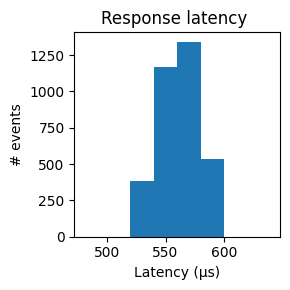

3420 samples, 306.9 ± 8.5 µs
min:288, max:332
Fraction of edge latencies < 2ms: 1.0000
Fraction of edge latencies < 1ms: 1.0000


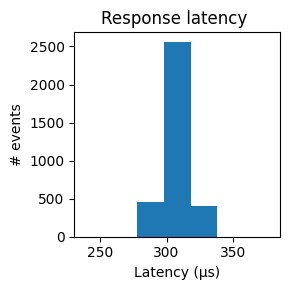

3420 samples, 841.5 ± 293.0 µs
min:546, max:9732
Fraction of edge latencies < 2ms: 0.9959
Fraction of edge latencies < 1ms: 0.8482


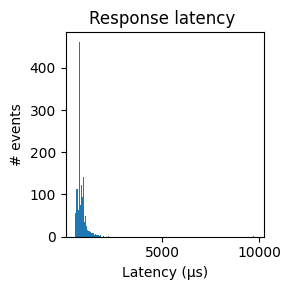

3422 samples, 372.0 ± 95.3 µs
min:286, max:4284
Fraction of edge latencies < 2ms: 0.9997
Fraction of edge latencies < 1ms: 0.9997


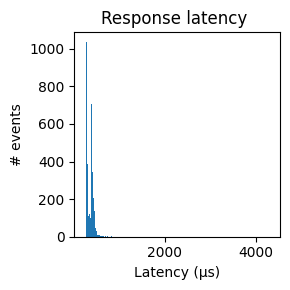

Error mean:-210, SD:281, min:-684, max:290
Fraction of errors < 1ms: 1.0000


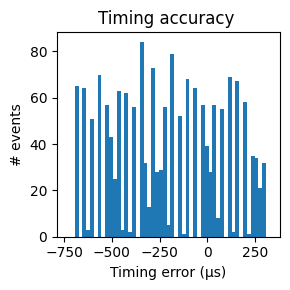

Error mean:-342, SD:285, min:-848, max:164
Fraction of errors < 1ms: 1.0000


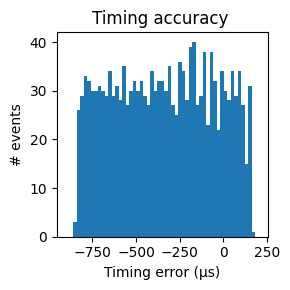

Error mean:-27, SD:351, min:-528, max:4694
Fraction of errors < 1ms: 0.9923


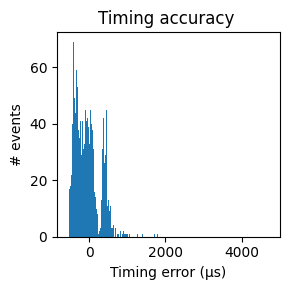

Error mean:-361, SD:280, min:-842, max:576
Fraction of errors < 1ms: 1.0000


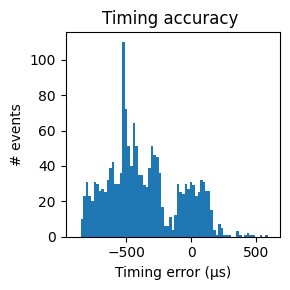

In [21]:
pyboard_noload_latencies = latency(get_data_from_npy('npy_data/t1-s3.npy'))
dseries_noload_latencies = latency(get_data_from_npy('npy_data/t2-s4.npy'))

pyboard_loaded_latencies = latency(get_data_from_npy('npy_data/t3-s3.npy'))
dseries_loaded_latencies = latency(get_data_from_npy('npy_data/t4-s3.npy'))

pyboard_noload_timing = timing_accuracy(get_data_from_npy('npy_data/t5-s1.npy'))
dseries_noload_timing = timing_accuracy(get_data_from_npy('npy_data/t6-s2.npy'))

pyboard_loaded_timing = timing_accuracy(get_data_from_npy('npy_data/t7-s1.npy'))
dseries_loaded_timing = timing_accuracy(get_data_from_npy('npy_data/t8-s2.npy'))


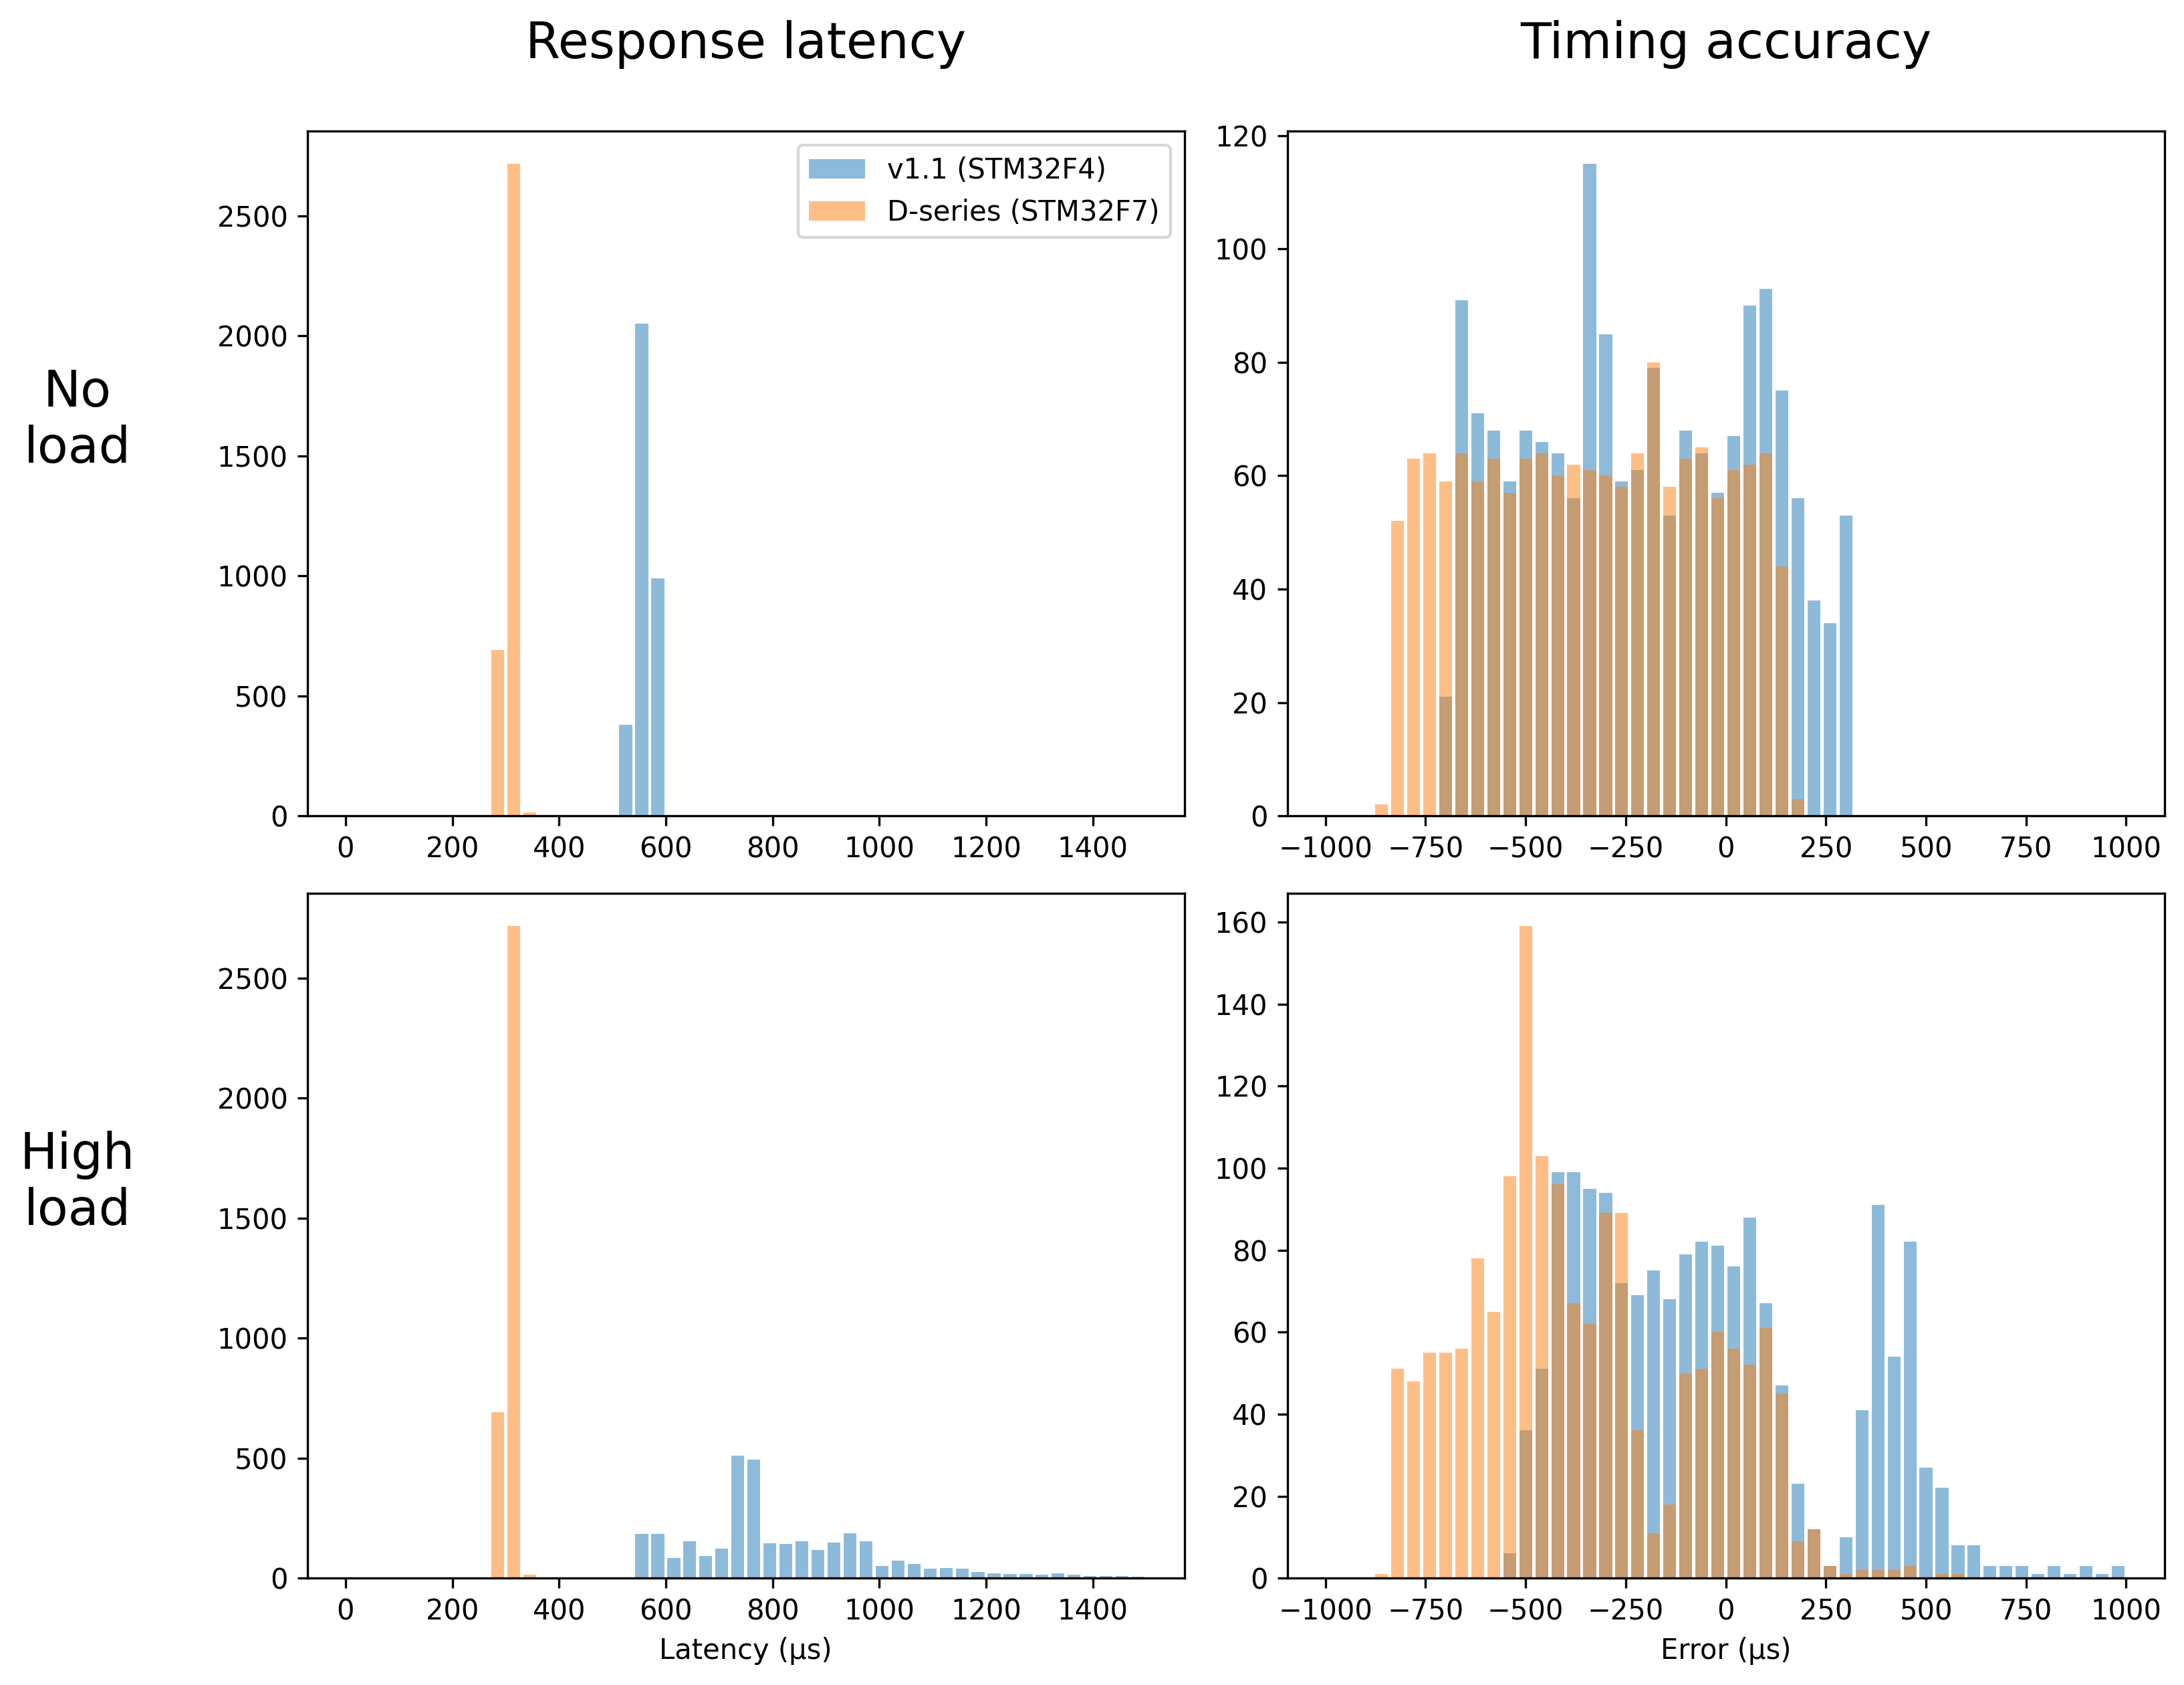

In [54]:
(
    fig,
    (
        (
            latency_noload,
            accuracy_noload,
        ),
        (latency_highload, accuracy_highload),
    ),
) = plt.subplots(nrows=2, ncols=2, figsize=(11, 8.5), dpi=300)

datasets = [
    pyboard_noload_latencies,
    dseries_noload_latencies,
    pyboard_loaded_latencies,
    dseries_noload_latencies,
    pyboard_noload_timing,
    dseries_noload_timing,
    pyboard_loaded_timing,
    dseries_loaded_timing,
]

numBins = 51


# latencies

# bins = np.linspace(0, 620, numBins)
bins = np.linspace(0, 1500, numBins)
latency_noload.hist(datasets[0], bins, alpha=0.5, label="v1.1 (STM32F4)", rwidth=0.8)
latency_noload.hist(
    datasets[1], bins, alpha=0.5, label="D-series (STM32F7)", rwidth=0.8
)
latency_noload.set_title("Response latency\n", fontsize=18)
latency_noload.set_ylabel("No\nload", fontsize=18, rotation=0, labelpad=50)
latency_noload.legend()

latency_highload.hist(datasets[2], bins, alpha=0.5, rwidth=0.8)
latency_highload.hist(
    np.clip(datasets[3], bins[0], bins[-1]),
    bins,
    alpha=0.5,
    rwidth=0.8,
)
latency_highload.set_xlabel("Latency (µs)")
latency_highload.set_ylabel("High\nload", fontsize=18, rotation=0, labelpad=50)


# accuracies
bins = np.linspace(-1000, 1000, numBins)
accuracy_noload.hist(datasets[4], bins, alpha=0.5, rwidth=0.8)
accuracy_noload.hist(datasets[5], bins, alpha=0.5, rwidth=0.8)
accuracy_noload.set_title("Timing accuracy\n", fontsize=18)

accuracy_highload.hist(datasets[6], bins, alpha=0.5, rwidth=0.8)
accuracy_highload.hist(
    np.clip(datasets[7], bins[0], bins[-1]),
    bins,
    alpha=0.5,
    label="D-series",
    rwidth=0.8,
)
accuracy_highload.set_xlabel("Error (µs)")

fig.tight_layout()
plt.show()
